# Panel data in pandas

Files needed = ('dogs.csv', 'WEOOct2016all.xls')

We are learning how to deal with complex datasets in pandas. We began by tackling the multiIndex and now we turn to panel data and its various representations.  

Panel data have (at least) three dimensions, for example, a panel might record
1. several variables (income, age, spending on cheese)
2. regarding several people
3. over time

The multiIndex gives us a natural way to handle this data.

In [1]:
import pandas as pd                 # load pandas and shorten it to pd
import datetime as dt               # load datetime and shorten it to dt
import matplotlib.pyplot as plt     # for making figures

### Some panel data
Load the 'dogs.csv' file. The different dimensions of the data are: **variables** (walks, snacks); **dogs** (Buster, Su); and  **time**.
 
The difference between the 'prem' dataset in the last notebook and this one is that the dogs dataset has a *time dimension.*

For reference, here are [Buster and Su](http://kjrs3.com/f19econ690/2_Pandas/best_dogs.jpg).
 

In [2]:
# load a data file with the number of walks and snacks my dogs have had 

dogs = pd.read_csv('dogs.csv')         # data on the habits of my dogs
dogs



,dog,var,time,value
0,Buster,walk,10/1/2018,2
1,Buster,walk,10/2/2018,2
2,Buster,walk,10/3/2018,1
3,Buster,snacks,10/1/2018,4
4,Buster,snacks,10/2/2018,3
5,Buster,snacks,10/3/2018,4
6,Buster,snacks,10/4/2018,5
7,Su,walk,10/1/2018,2
8,Su,walk,10/2/2018,2
9,Su,walk,10/3/2018,2


### Long vs. wide (or stacked vs. unstacked)

This data format is called **long** because there are lots of rows and not many columns. Moving between long and **wide** (lots of columns, fewer rows) is a common task in setting up panel data sets. 

Pandas calls long data **stacked** and wide data **unstacked**. We use the `stack()` and `unstack()` methods for moving between long and wide with multiIndexed data. Stack and unstack do not work in place. They always return a copy, so we need to assign it to a variable.

### Set up the index

In [3]:
dogs['time'] = pd.to_datetime(dogs['time'])

# move everything but the data values to the index
dogs = dogs.set_index(['dog', 'time', 'var'])
dogs


value
dog    time       var          
Buster 2018-10-01 walk        2
       2018-10-02 walk        2
       2018-10-03 walk        1
       2018-10-01 snacks      4
       2018-10-02 snacks      3
       2018-10-03 snacks      4
       2018-10-04 snacks      5
Su     2018-10-01 walk        2
       2018-10-02 walk        2
       2018-10-03 walk        2
       2018-10-01 snacks      3
       2018-10-02 snacks      4
       2018-10-03 snacks      4
       2018-10-04 snacks      3

### Unstack
We **unstack the data** to put the variables into columns. 

In [4]:
# Moving var to a column creates a multiIndex with two levels

dogs_us = dogs.unstack('var') 
dogs_us

value     
var               snacks walk
dog    time                  
Buster 2018-10-01    4.0  2.0
       2018-10-02    3.0  2.0
       2018-10-03    4.0  1.0
       2018-10-04    5.0  NaN
Su     2018-10-01    3.0  2.0
       2018-10-02    4.0  2.0
       2018-10-03    4.0  2.0
       2018-10-04    3.0  NaN

In [5]:
dogs_us.columns

MultiIndex(levels=[['value'], ['snacks', 'walk']],
           codes=[[0, 0], [0, 1]],
           names=[None, 'var'])

We can unstack several variables. As usual, we pass a list. 

In [6]:
dogs_us = dogs.unstack(['dog', 'var']) # move dog and var to columns, creates a multiindex with three levels
dogs_us

value                   
dog        Buster          Su       
var          walk snacks walk snacks
time                                
2018-10-01    2.0    4.0  2.0    3.0
2018-10-02    2.0    3.0  2.0    4.0
2018-10-03    1.0    4.0  2.0    4.0
2018-10-04    NaN    5.0  NaN    3.0

In [7]:
dogs_us.columns

MultiIndex(levels=[['value'], ['Buster', 'Su'], ['snacks', 'walk']],
           codes=[[0, 0, 0, 0], [0, 0, 1, 1], [1, 0, 1, 0]],
           names=[None, 'dog', 'var'])

### Removing a level
The outermost level of the column multiIndex is 'value' and is not very useful. Let's drop it.

Note that the level does not have a name associated with it (`None` is not a name) so we need to use the number associate with the level. 

In [8]:
dogs_us.columns = dogs_us.columns.droplevel(level = 0)
dogs_us

dog        Buster          Su       
var          walk snacks walk snacks
time                                
2018-10-01    2.0    4.0  2.0    3.0
2018-10-02    2.0    3.0  2.0    4.0
2018-10-03    1.0    4.0  2.0    4.0
2018-10-04    NaN    5.0  NaN    3.0

We now have an unstacked DataFrame and each column is a time series of one dog's observations (the data are 'wide'). 
Notice that we do not have observations for **2018-10-04** walks, so panda filled in `NaN`s for us. 

Panel data like this are STATA's bread and butter, and STATA has a lot of tools for working with panels. Pandas does not have as large a toolset, but the multiIndex provides a very nice way to handle and display panel data. STATA does not have a multiIndex, so the column names in the data above would be: 'walkBuster', 'snacksBuster', 'walkSu', 'snacksSu'. 

### Creating new variables
I want to know the walk-to-snacks ratio to make sure they are getting enough exercise. We can refer to columns in the multiIndex using tuples. 

In [9]:
# compute the ratios
dogs_us[('Buster', 'ws_ratio')] =  dogs_us[('Buster', 'walk')]/dogs_us[('Buster', 'snacks')]
dogs_us[('Su', 'ws_ratio')] =  dogs_us[('Su', 'walk')]/dogs_us[('Su', 'snacks')]

# resort the index
dogs_us.sort_index(axis=1, inplace=True)
dogs_us


dog        Buster                    Su               
var        snacks walk  ws_ratio snacks walk  ws_ratio
time                                                  
2018-10-01    4.0  2.0  0.500000    3.0  2.0  0.666667
2018-10-02    3.0  2.0  0.666667    4.0  2.0  0.500000
2018-10-03    4.0  1.0  0.250000    4.0  2.0  0.500000
2018-10-04    5.0  NaN       NaN    3.0  NaN       NaN

### Ploting with panels
Let's plot the walk-snack ratio. There are several things in this code to talk about...

C:\Users\kimru\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


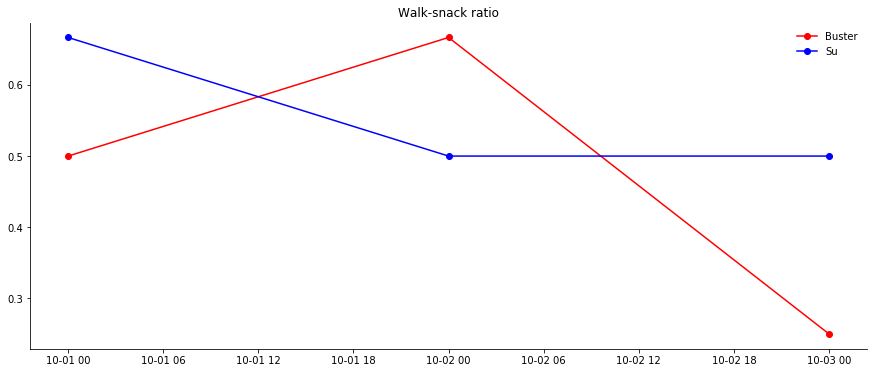

In [10]:
# A stealthy import --- I usually put these in the first cell
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15,6))

ax.plot(dogs_us.index, dogs_us[('Buster', 'ws_ratio')], color='red', marker = 'o', label='Buster')
ax.plot(dogs_us.index, dogs_us[('Su', 'ws_ratio')], color='blue', marker = 'o', label='Su')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Walk-snack ratio')
ax.legend(frameon=False)

# Here I am formatting the x-axis dates
# ax.set_xticks(dogs_us.index)                                  # put ticks only where we have observations
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))   #show the month and day

plt.show()



Looks pretty good, but Buster needs more walks. Let's dig into this a bit more.

### 1. Alternative plot command
In the figure above, I separately plotted Buster's and Su's data. 
1. This let me specify a label to get the legend correct
2. It makes it clear how I specify each line color, width, marker, etc

In the figure below, I plot the index (the dates) against all the `ws_ratio`. This is a fast way to plot many lines.
1. I have to handle the legend labels separately
2. I am using matplotlib's default color cycler



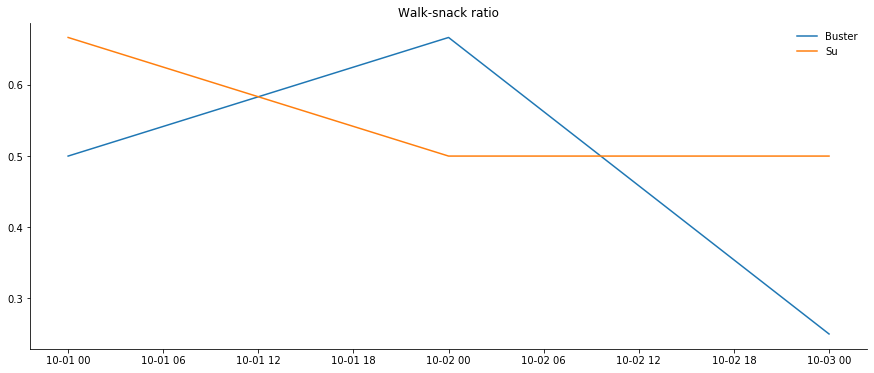

In [11]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(dogs_us.index, dogs_us.xs('ws_ratio', level=1, axis=1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Walk-snack ratio')
#ax.legend(frameon=False)

ax.legend(dogs_us.columns.get_level_values(level='dog').unique(), frameon=False)

# Here I am formatting the x-axis dates
# ax.set_xticks(dogs_us.index)                                  # put ticks only where we have observations
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))   #show the month and day

plt.show()

### Legends

Comment out the more complicated legend code above and use our standard `ax.legend(frameon=False)` code. What happened? Matplotlib wasn't sure what to do about the legend labels, so it bonked.

To add labels to the legend:
1. Get the values of the column names (at which level?)
2. They are repeated, so pull out the unique values
3. Assign the values to the legend

In [12]:
# Here is get_level_values
print(dogs_us.columns.get_level_values(level='dog'))

# Here is get the unique levels
print(dogs_us.columns.get_level_values(level='dog').unique())

Index(['Buster', 'Buster', 'Buster', 'Su', 'Su', 'Su'], dtype='object', name='dog')
Index(['Buster', 'Su'], dtype='object', name='dog')


In general, legends are very flexible and potentially complicated. We will talk more about them later. 

### 2.  An aside on datetime axes
**The Problem:** The x-axis range is small, so matplotlib has added some labels with days broken up in hours. The data are not collected by the hour, so this axis is misleading. I only have daily observations.

I am exerting some control over the x-axis ticks and labels here. 
```python
ax.set_xticks(dogs_us.index)   
```
specifies that I want ticks at the values in the index --- and only at these places.

The code
```python 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
```
tells matplotlib to format the tick labels as month-day. To use this second line of code, I needed to import the mdates (**m**atplotlib **dates**) part of the matplotlib package.

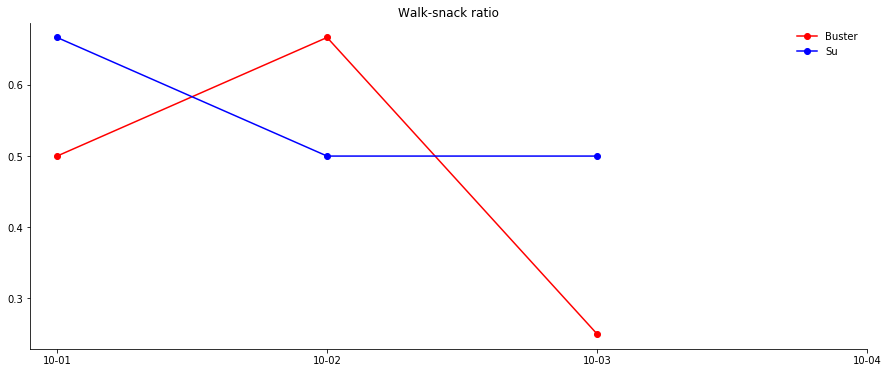

In [13]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(dogs_us.index, dogs_us[('Buster', 'ws_ratio')], color='red', marker = 'o', label='Buster')
ax.plot(dogs_us.index, dogs_us[('Su', 'ws_ratio')], color='blue', marker = 'o', label='Su')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Walk-snack ratio')

# Here I am formatting the x-axis dates
ax.set_xticks(dogs_us.index)                                  # put ticks only where we have observations
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))   #show the month and day

ax.legend(frameon=False)

plt.show()



\[To try at home: We don't have data points for 10-04. Change the x-axis limits to that it only spans 10-01 to 10-03.\]

### Stack
We can **stack the data** to put the variables back on the rows. 

When we stack the data, pandas defaults to dropping the NaNs. We can override this if we choose. If we do not pass an argument, it stacks the innermost index. 

In [14]:
# stack just one level
dogs_s = dogs_us.stack()       # stack shifts the columns to rows. 
dogs_s

dog                    Buster        Su
time       var                         
2018-10-01 snacks    4.000000  3.000000
           walk      2.000000  2.000000
           ws_ratio  0.500000  0.666667
2018-10-02 snacks    3.000000  4.000000
           walk      2.000000  2.000000
           ws_ratio  0.666667  0.500000
2018-10-03 snacks    4.000000  4.000000
           walk      1.000000  2.000000
           ws_ratio  0.250000  0.500000
2018-10-04 snacks    5.000000  3.000000

In [15]:
# stack two levels (and keep the missings)
dogs_s = dogs_us.stack(['dog', 'var'], dropna=False)
dogs_s

time        dog     var     
2018-10-01  Buster  snacks      4.000000
                    walk        2.000000
                    ws_ratio    0.500000
            Su      snacks      3.000000
                    walk        2.000000
                    ws_ratio    0.666667
2018-10-02  Buster  snacks      3.000000
                    walk        2.000000
                    ws_ratio    0.666667
            Su      snacks      4.000000
                    walk        2.000000
                    ws_ratio    0.500000
2018-10-03  Buster  snacks      4.000000
                    walk        1.000000
                    ws_ratio    0.250000
            Su      snacks      4.000000
                    walk        2.000000
                    ws_ratio    0.500000
2018-10-04  Buster  snacks      5.000000
                    walk             NaN
                    ws_ratio         NaN
            Su      snacks      3.000000
                    walk             NaN
                    ws_ratio

The data are back to 'long' form. Note that we have a series now, and not a DataFrame. 

I would like dog as the outermost index. Use the `swaplevel()` to swap two levels. 

In [16]:
dogs_s=dogs_s.swaplevel('dog', 'time')
dogs_s

dog     time        var     
Buster  2018-10-01  snacks      4.000000
                    walk        2.000000
                    ws_ratio    0.500000
Su      2018-10-01  snacks      3.000000
                    walk        2.000000
                    ws_ratio    0.666667
Buster  2018-10-02  snacks      3.000000
                    walk        2.000000
                    ws_ratio    0.666667
Su      2018-10-02  snacks      4.000000
                    walk        2.000000
                    ws_ratio    0.500000
Buster  2018-10-03  snacks      4.000000
                    walk        1.000000
                    ws_ratio    0.250000
Su      2018-10-03  snacks      4.000000
                    walk        2.000000
                    ws_ratio    0.500000
Buster  2018-10-04  snacks      5.000000
                    walk             NaN
                    ws_ratio         NaN
Su      2018-10-04  snacks      3.000000
                    walk             NaN
                    ws_ratio

In [17]:
# and swap var for time, so time is the innermost index
dogs_s=dogs_s.swaplevel('var', 'time')
dogs_s

dog     var       time      
Buster  snacks    2018-10-01    4.000000
        walk      2018-10-01    2.000000
        ws_ratio  2018-10-01    0.500000
Su      snacks    2018-10-01    3.000000
        walk      2018-10-01    2.000000
        ws_ratio  2018-10-01    0.666667
Buster  snacks    2018-10-02    3.000000
        walk      2018-10-02    2.000000
        ws_ratio  2018-10-02    0.666667
Su      snacks    2018-10-02    4.000000
        walk      2018-10-02    2.000000
        ws_ratio  2018-10-02    0.500000
Buster  snacks    2018-10-03    4.000000
        walk      2018-10-03    1.000000
        ws_ratio  2018-10-03    0.250000
Su      snacks    2018-10-03    4.000000
        walk      2018-10-03    2.000000
        ws_ratio  2018-10-03    0.500000
Buster  snacks    2018-10-04    5.000000
        walk      2018-10-04         NaN
        ws_ratio  2018-10-04         NaN
Su      snacks    2018-10-04    3.000000
        walk      2018-10-04         NaN
        ws_ratio  2018-10-04

In [18]:
# and give it a sorting...
dogs_s.sort_index(inplace=True)
dogs_s

dog     var       time      
Buster  snacks    2018-10-01    4.000000
                  2018-10-02    3.000000
                  2018-10-03    4.000000
                  2018-10-04    5.000000
        walk      2018-10-01    2.000000
                  2018-10-02    2.000000
                  2018-10-03    1.000000
                  2018-10-04         NaN
        ws_ratio  2018-10-01    0.500000
                  2018-10-02    0.666667
                  2018-10-03    0.250000
                  2018-10-04         NaN
Su      snacks    2018-10-01    3.000000
                  2018-10-02    4.000000
                  2018-10-03    4.000000
                  2018-10-04    3.000000
        walk      2018-10-01    2.000000
                  2018-10-02    2.000000
                  2018-10-03    2.000000
                  2018-10-04         NaN
        ws_ratio  2018-10-01    0.666667
                  2018-10-02    0.500000
                  2018-10-03    0.500000
                  2018-10-04

Let's get this ready to save as long data, like it was when we read it in.
1. Reset the index to move them back to columns
2. Give the value column a name

In [19]:
dogs_s = dogs_s.reset_index()
dogs_s

,dog,var,time,0
0,Buster,snacks,2018-10-01,4.000000
1,Buster,snacks,2018-10-02,3.000000
2,Buster,snacks,2018-10-03,4.000000
3,Buster,snacks,2018-10-04,5.000000
4,Buster,walk,2018-10-01,2.000000
5,Buster,walk,2018-10-02,2.000000
6,Buster,walk,2018-10-03,1.000000
7,Buster,walk,2018-10-04,NaN
8,Buster,ws_ratio,2018-10-01,0.500000
9,Buster,ws_ratio,2018-10-02,0.666667


In [20]:
dogs_s.rename(columns={0 :'value'}, inplace=True)
dogs_s

,dog,var,time,value
0,Buster,snacks,2018-10-01,4.000000
1,Buster,snacks,2018-10-02,3.000000
2,Buster,snacks,2018-10-03,4.000000
3,Buster,snacks,2018-10-04,5.000000
4,Buster,walk,2018-10-01,2.000000
5,Buster,walk,2018-10-02,2.000000
6,Buster,walk,2018-10-03,1.000000
7,Buster,walk,2018-10-04,NaN
8,Buster,ws_ratio,2018-10-01,0.500000
9,Buster,ws_ratio,2018-10-02,0.666667


In [21]:
# Now save it. 
dogs_s.to_csv('dog_data_updated.csv', index=False)  #index = False does not print the index

## Practice

Let's review multiIndexing with some real world data. The data are messy and will require some cleaning up and 'wrangling.' We will do some of it together, then I'll  hand it off for you all to finish. 

We will work with the IMF's [World Economic Outlook](https://www.imf.org/external/pubs/ft/weo/2017/02/weodata/download.aspx), which contains historical data and the IMF's forecasts for many countries and variables. 

Our **goal** is to study the evolution of debt in Germany, Argentina, and Greece. 

First, download the data file. The file is here [http://www.imf.org/external/pubs/ft/weo/2016/02/weodata/WEOOct2016all.xls](http://www.imf.org/external/pubs/ft/weo/2016/02/weodata/WEOOct2016all.xls). Clicking on the link should initiate a download.

Wow, there is a lot going on here. Let's get to work.

### Read the data into a DataFrame
Read in the data, then inspect the head and tail to make sure it looks as expected.

In [36]:
# The IMF website is acting up and the url doesn't always work
# url = 'http://www.imf.org/external/pubs/ft/weo/2016/02/weodata/WEOOct2016all.xls'

# The data are in a tab-separated list (even though the file ends in 'xls'. Not cool, IMF)
# The thousands parameter tells pandas to remove the comma when reading in numbers
weo = pd.read_csv('WEOOct2016all.xls', sep='\t', na_values=['n/a', '--'], thousands =',')
weo.head()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf4 in position 1: invalid continuation byte

### A quick aside about encoding
What the heck just happened? What is a `UnicodeDecodeError`?

Any 'text' character (be it latin, cyrilic, korean, chinese,...) must be translated to a series of 0s and 1s in order for a computer to understand it. This translation is known as an encoding. As computers developed, many different groups created many different encodings (e.g., ASCII), so the letter 'K' may translate to 0010 in one encoding and 00100101 in another. What a mess. 

At some point [Unicode](https://en.wikipedia.org/wiki/Unicode) was developed to serve as one standard encoding. Pandas defaults to utf-8 encoding. The world is converging on unicode, but other encoding are still out there. 

The error message tells us that the IMF is not encoding its ~~workbook~~ tab-delimited file as utf-8. After a bit of digging, I found the file to be encoded in 'windows-1252'. (Now is not the time for a discussion of the bureaucratic nightmares of large international organizations, but this is a nice example.) 

That's probably more than you ever wanted to know about text, but it's a scary world out there. If you try reading a file and pandas throws a unicode error, then you probably need to change the encoding. 

The `read_` methods of pandas (and other python methods) takes a parameter `encoding` to specify the file encoding. When we do not specify the encoding, pandas defaults to utf-8. Let's add the encoding parameter and try again.

In [23]:
# url = 'http://www.imf.org/external/pubs/ft/weo/2016/02/weodata/WEOOct2016all.xls'

# The data are in a tab-separated list (even though the file ends in 'xls'. Not cool, IMF)
# The encoding parameter tells pandas how to read special characters
# The thousands parameter tells pandas to remove the comma when reading in numbers
weo = pd.read_csv('WEOOct2016all.xls', sep='\t', na_values=['n/a', '--'], thousands =',', encoding='windows-1252')
weo.head()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,457.654,463.520,467.035,476.376,492.572,513.877,540.766,571.302,605.580,2014.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,3.933,1.282,0.758,2.000,3.400,4.325,5.233,5.647,6.000,2014.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,1116.827,1167.905,1203.671,1283.049,1406.268,1569.305,1766.209,1995.217,2261.041,2014.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,20.170,20.352,19.687,18.395,19.290,20.604,22.297,24.222,26.392,2014.0
4,512,AFG,NGDP_D,Afghanistan,"Gross domestic product, deflator",The GDP deflator is derived by dividing curren...,Index,NaN,"See notes for: Gross domestic product, consta...",NaN,...,244.033,251.964,257.726,269.336,285.495,305.385,326.613,349.240,373.368,2014.0


In [24]:
weo.tail()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Estimates Start After
8400,698,ZWE,GGXWDG_NGDP,Zimbabwe,General government gross debt,Gross debt consists of all liabilities that re...,Percent of GDP,NaN,See notes for: General government gross debt ...,NaN,...,54.559,55.273,58.899,58.859,57.587,57.056,58.202,56.637,58.524,2014.0
8401,698,ZWE,NGDP_FY,Zimbabwe,Gross domestic product corresponding to fiscal...,Gross domestic product corresponding to fiscal...,National currency,Billions,Source: Ministry of Finance or Treasury Latest...,NaN,...,13.490,14.197,14.170,14.193,14.556,15.025,15.525,16.072,16.661,2014.0
8402,698,ZWE,BCA,Zimbabwe,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,Source: Reserve Bank of Zimbabwe and Ministry ...,-0.301,...,-2.461,-2.156,-1.520,-1.069,-0.893,-1.370,-1.424,-1.500,-1.599,2013.0
8403,698,ZWE,BCA_NGDPD,Zimbabwe,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,"See notes for: Gross domestic product, curren...",NaN,...,-18.242,-15.186,-10.729,-7.534,-6.132,-9.122,-9.172,-9.331,-9.600,2013.0
8404,"International Monetary Fund, World Economic Ou...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data file has a footer (go back and look in the file) and we read it in as a line of data. We could go back and specify the `skipfooter` parameter to `read_csv()`, but we can also just drop it.

In [25]:
weo.drop(8404, inplace=True)   # Using the row number is not very robust. What if the IMF added more countries to the workbook?
weo.tail()

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Estimates Start After
8399,698,ZWE,GGXWDG,Zimbabwe,General government gross debt,Gross debt consists of all liabilities that re...,National currency,Billions,Source: Ministry of Finance or Treasury Latest...,NaN,...,7.360,7.847,8.346,8.354,8.382,8.572,9.036,9.103,9.751,2014.0
8400,698,ZWE,GGXWDG_NGDP,Zimbabwe,General government gross debt,Gross debt consists of all liabilities that re...,Percent of GDP,NaN,See notes for: General government gross debt ...,NaN,...,54.559,55.273,58.899,58.859,57.587,57.056,58.202,56.637,58.524,2014.0
8401,698,ZWE,NGDP_FY,Zimbabwe,Gross domestic product corresponding to fiscal...,Gross domestic product corresponding to fiscal...,National currency,Billions,Source: Ministry of Finance or Treasury Latest...,NaN,...,13.490,14.197,14.170,14.193,14.556,15.025,15.525,16.072,16.661,2014.0
8402,698,ZWE,BCA,Zimbabwe,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,Source: Reserve Bank of Zimbabwe and Ministry ...,-0.301,...,-2.461,-2.156,-1.520,-1.069,-0.893,-1.370,-1.424,-1.500,-1.599,2013.0
8403,698,ZWE,BCA_NGDPD,Zimbabwe,Current account balance,Current account is all transactions other than...,Percent of GDP,NaN,"See notes for: Gross domestic product, curren...",NaN,...,-18.242,-15.186,-10.729,-7.534,-6.132,-9.122,-9.172,-9.331,-9.600,2013.0


### Drop unneeded variables
Use `drop()` to get rid of columns that we are not going to use.

In [26]:
weo.drop(['WEO Country Code', 'Subject Notes', 'Country/Series-specific Notes', 'Scale', 'Estimates Start After'],axis=1, inplace=True)
weo.head()

,ISO,WEO Subject Code,Country,Subject Descriptor,Units,1980,1981,1982,1983,1984,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",National currency,NaN,NaN,NaN,NaN,NaN,...,440.336,457.654,463.520,467.035,476.376,492.572,513.877,540.766,571.302,605.580
1,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Percent change,NaN,NaN,NaN,NaN,NaN,...,13.968,3.933,1.282,0.758,2.000,3.400,4.325,5.233,5.647,6.000
2,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",National currency,NaN,NaN,NaN,NaN,NaN,...,1033.591,1116.827,1167.905,1203.671,1283.049,1406.268,1569.305,1766.209,1995.217,2261.041
3,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",U.S. dollars,NaN,NaN,NaN,NaN,NaN,...,20.296,20.170,20.352,19.687,18.395,19.290,20.604,22.297,24.222,26.392
4,AFG,NGDP_D,Afghanistan,"Gross domestic product, deflator",Index,NaN,NaN,NaN,NaN,NaN,...,234.728,244.033,251.964,257.726,269.336,285.495,305.385,326.613,349.240,373.368


### Keep the countries and variables we want
Let's look at Argentina, Germany, and Greece and the variables debt-gdp ratio and deficit-gdp ratio. We will use this as an opportunity to learn about the `.isin( )` method of DataFrame.

In [27]:
variables = ['GGXWDG_NGDP', 'GGXCNL_NGDP']
countries = ['ARG', 'DEU', 'GRC']

weo = weo[ weo['WEO Subject Code'].isin(variables) & weo['ISO'].isin(countries) ]
weo.head()

,ISO,WEO Subject Code,Country,Subject Descriptor,Units,1980,1981,1982,1983,1984,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
252,ARG,GGXCNL_NGDP,Argentina,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,-2.802,-3.001,-3.990,-6.630,-7.123,-7.383,-6.579,-5.450,-4.307,-4.149
260,ARG,GGXWDG_NGDP,Argentina,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,39.434,42.195,43.587,52.131,51.751,50.716,51.199,50.495,49.322,48.860
2716,DEU,GGXCNL_NGDP,Germany,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,-0.050,-0.203,0.278,0.745,0.129,0.132,0.234,0.427,0.523,0.590
2724,DEU,GGXWDG_NGDP,Germany,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,79.516,77.058,74.480,70.988,68.169,65.948,63.601,61.120,58.905,56.676
2804,GRC,GGXCNL_NGDP,Greece,General government net lending/borrowing,Percent of GDP,-2.774,-7.847,-6.092,-6.847,-7.976,...,-6.506,-3.531,-4.054,-3.080,-3.359,-2.721,-1.690,-1.716,-1.997,-2.585


### The isin() method
Check out the way that I selected the rows of the DataFrame I wanted. I used the `isin()` method ([docs](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isin.html)). You pass it a list of values and it returns a DataFrame of bools which you use to subset the data. This is a lot cleaner than using a bunch of conditional statements.  

I'm using it twice: once to specify the variables I want and once to specify the countries I want. I join the two together with an & operator.  

### Your turn
The data are in pretty decent shape. Take a few minutes and try the following. Feel free to chat with those around if you get stuck. I am here, too.

1. Rename the 'WEO Subject Code' to 'Variable' and 'Subject Descriptor' to 'Description'.

In [28]:
weo.rename(columns={'WEO Subject Code':'Variable', 'Subject Descriptor':'Description'}, inplace = True)
weo.head()

,ISO,Variable,Country,Description,Units,1980,1981,1982,1983,1984,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
252,ARG,GGXCNL_NGDP,Argentina,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,-2.802,-3.001,-3.990,-6.630,-7.123,-7.383,-6.579,-5.450,-4.307,-4.149
260,ARG,GGXWDG_NGDP,Argentina,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,39.434,42.195,43.587,52.131,51.751,50.716,51.199,50.495,49.322,48.860
2716,DEU,GGXCNL_NGDP,Germany,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,-0.050,-0.203,0.278,0.745,0.129,0.132,0.234,0.427,0.523,0.590
2724,DEU,GGXWDG_NGDP,Germany,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,79.516,77.058,74.480,70.988,68.169,65.948,63.601,61.120,58.905,56.676
2804,GRC,GGXCNL_NGDP,Greece,General government net lending/borrowing,Percent of GDP,-2.774,-7.847,-6.092,-6.847,-7.976,...,-6.506,-3.531,-4.054,-3.080,-3.359,-2.721,-1.690,-1.716,-1.997,-2.585


2. Replace 'GGXCNL_NGDP' with 'Surplus
3. Replace 'GGXWDG_NGDP' with 'Debt'

In [29]:
weo.loc[weo['Variable']=='GGXCNL_NGDP','Variable'] = 'Surplus' 
weo.loc[weo['Variable']=='GGXWDG_NGDP','Variable'] = 'Debt' 
weo.head()

,ISO,Variable,Country,Description,Units,1980,1981,1982,1983,1984,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
252,ARG,Surplus,Argentina,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,-2.802,-3.001,-3.990,-6.630,-7.123,-7.383,-6.579,-5.450,-4.307,-4.149
260,ARG,Debt,Argentina,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,39.434,42.195,43.587,52.131,51.751,50.716,51.199,50.495,49.322,48.860
2716,DEU,Surplus,Germany,General government net lending/borrowing,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,-0.050,-0.203,0.278,0.745,0.129,0.132,0.234,0.427,0.523,0.590
2724,DEU,Debt,Germany,General government gross debt,Percent of GDP,NaN,NaN,NaN,NaN,NaN,...,79.516,77.058,74.480,70.988,68.169,65.948,63.601,61.120,58.905,56.676
2804,GRC,Surplus,Greece,General government net lending/borrowing,Percent of GDP,-2.774,-7.847,-6.092,-6.847,-7.976,...,-6.506,-3.531,-4.054,-3.080,-3.359,-2.721,-1.690,-1.716,-1.997,-2.585


4. Set the (row) multiIndex to be 'ISO', 'Variable', 'Country', 'Description', and 'Units', in that order. 

In [30]:
weo.set_index(['ISO', 'Variable', 'Country',  'Description', 'Units'], inplace=True)
weo.head()

1980  \
ISO Variable Country   Description                              Units                   
ARG Surplus  Argentina General government net lending/borrowing Percent of GDP    NaN   
    Debt     Argentina General government gross debt            Percent of GDP    NaN   
DEU Surplus  Germany   General government net lending/borrowing Percent of GDP    NaN   
    Debt     Germany   General government gross debt            Percent of GDP    NaN   
GRC Surplus  Greece    General government net lending/borrowing Percent of GDP -2.774   

                                                                                 1981  \
ISO Variable Country   Description                              Units                   
ARG Surplus  Argentina General government net lending/borrowing Percent of GDP    NaN   
    Debt     Argentina General government gross debt            Percent of GDP    NaN   
DEU Surplus  Germany   General government net lending/borrowing Percent of GDP    NaN   
    Debt     Germany   General government gross debt            Percent of GDP    NaN   
GRC Surplus  Greece    General government net lending/borrowing Percent of GDP -7.847   

                                                                                 1982  \
ISO Variable Country   Description                              Units                   
ARG Surplus  Argentina General government net lending/borrowing Percent of GDP    NaN   
    Debt     Argentina General government gross debt            Percent of GDP    NaN   
DEU Surplus  Germany   General government net lending/borrowing Percent of GDP    NaN   
    Debt     Germany   General government gross debt            Percent of GDP    NaN   
GRC Surplus  Greece    General government net lending/borrowing Percent of GDP -6.092   

                                                                                 1983  \
ISO Variable Country   Description                              Units                   
ARG Surplus  Argentina General government net lending/borrowing Percent of GDP    NaN   
    Debt     Argentina General government gross debt            Percent of GDP    NaN   
DEU Surplus  Germany   General government net lending/borrowing Percent of GDP    NaN   
    Debt     Germany   General government gross debt            Percent of GDP    NaN   
GRC Surplus  Greece    General government net lending/borrowing Percent of GDP -6.847   

                                                                                 1984  \
ISO Variable Country   Description                              Units                   
ARG Surplus  Argentina General government net lending/borrowing Percent of GDP    NaN   
    Debt     Argentina General government gross debt            Percent of GDP    NaN   
DEU Surplus  Germany   General government net lending/borrowing Percent of GDP    NaN   
    Debt     Germany   General government gross debt            Percent of GDP    NaN   
GRC Surplus  Greece    General government net lending/borrowing Percent of GDP -7.976   

                                                                                  1985  \
ISO Variable Country   Description                              Units                    
ARG Surplus  Argentina General government net lending/borrowing Percent of GDP     NaN   
    Debt     Argentina General government gross debt            Percent of GDP     NaN   
DEU Surplus  Germany   General government net lending/borrowing Percent of GDP     NaN   
    Debt     Germany   General government gross debt            Percent of GDP     NaN   
GRC Surplus  Greece    General government net lending/borrowing Percent of GDP -10.603   

                                                                                 1986  \
ISO Variable Country   Description                              Units                   
ARG Surplus  Argentina General government net lending/borrowing Percent of GDP    NaN   
    Debt     Argentina General government gross debt           

5. We want the row to be time and everything else to be columns. Swap the columns for rows using `.transpose()`.
6. Sort the row and column indexes.

In [31]:
weo = weo.transpose()
weo.sort_index(axis=1, inplace=True)
weo.sort_index(axis=0, inplace=True)
weo.head()

ISO                                   ARG  \
Variable                             Debt   
Country                         Argentina   
Description General government gross debt   
Units                      Percent of GDP   
1980                                  NaN   
1981                                  NaN   
1982                                  NaN   
1983                                  NaN   
1984                                  NaN   

ISO                                                   \
Variable                                     Surplus   
Country                                    Argentina   
Description General government net lending/borrowing   
Units                                 Percent of GDP   
1980                                             NaN   
1981                                             NaN   
1982                                             NaN   
1983                                             NaN   
1984                                             NaN   

ISO                                   DEU  \
Variable                             Debt   
Country                           Germany   
Description General government gross debt   
Units                      Percent of GDP   
1980                                  NaN   
1981                                  NaN   
1982                                  NaN   
1983                                  NaN   
1984                                  NaN   

ISO                                                   \
Variable                                     Surplus   
Country                                      Germany   
Description General government net lending/borrowing   
Units                                 Percent of GDP   
1980                                             NaN   
1981                                             NaN   
1982                                             NaN   
1983                                             NaN   
1984                                             NaN   

ISO                                   GRC  \
Variable                             Debt   
Country                            Greece   
Description General government gross debt   
Units                      Percent of GDP   
1980                               22.526   
1981                               26.681   
1982                               29.310   
1983                               33.591   
1984                               40.061   

ISO                                                   
Variable                                     Surplus  
Country                                       Greece  
Description General government net lending/borrowing  
Units                                 Percent of GDP  
1980                                          -2.774  
1981                                          -7.847  
1982                                          -6.092  
1983                                          -6.847  
1984                                          -7.976

7. Plot debt levels for Argentina, Germany and Greece for all the years in the data. Add a legend. Make the figure look nice. Hint: The x-axis is time...

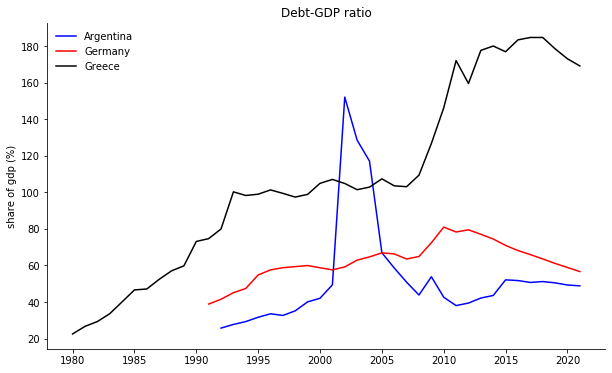

In [32]:
weo.index = pd.to_datetime(weo.index)      # Set the index to be a datetime object
                                           # This allows matplotlib to treat the axis as time

fig, ax = plt.subplots(figsize=(10,6))

# Three different ways to index the data we want to plot:

# 1. Here I use a tuple for the multiIndex 
ax.plot(weo.index, weo[('ARG', 'Debt')], color='blue', label = 'Argentina')   

# 2. Here I do not use the tuple --- it works, too   
ax.plot(weo.index, weo['DEU', 'Debt'], color='red', label = 'Germany')  

# 3. Here I use .loc[rows, cols] and I need to use the tuple to call out the column 
ax.plot(weo.index, weo.loc[:,('GRC', 'Debt')], color='black', label = 'Greece')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Debt-GDP ratio')
ax.set_ylabel('share of gdp (%)')

ax.legend(frameon=False)

plt.show()

Wow, Greece has had an interesting run. Let's look at Greece more closely. 
8. Create a (2,1) grid of subplots. Plot Greece's surplus in the top axes and debt in the bottom axis. Make it look nice.

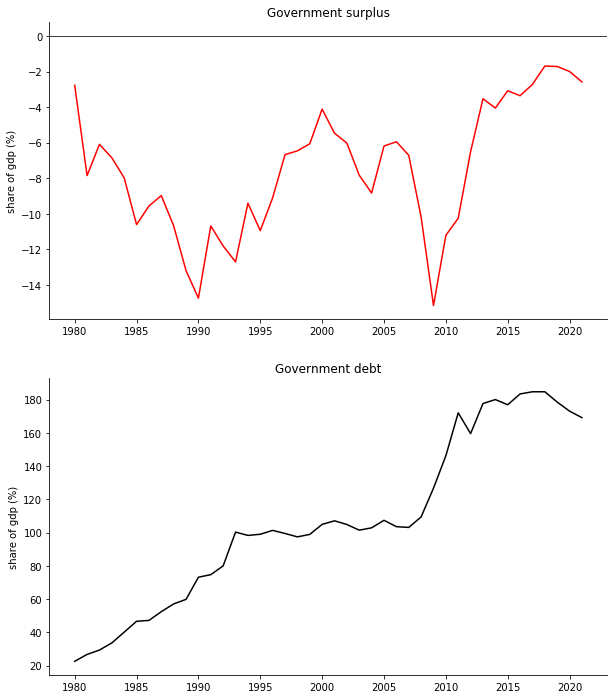

In [33]:
fig, ax = plt.subplots(2,1, figsize=(10,12))


ax[0].plot(weo.index, weo['GRC', 'Surplus'], color='red', label = 'Germany')
ax[0].set_title('Government surplus')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_ylabel('share of gdp (%)')
ax[0].axhline(y=0, color='black', linewidth=0.75)


ax[1].plot(weo.index, weo['GRC', 'Debt'], color='black', label = 'Greece')
ax[1].set_title('Government debt')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_ylabel('share of gdp (%)')

plt.show()

9. Stack the data to create a long dataset
10. Save the stacked data as a csv file

In [34]:
weo_s = weo.stack(['ISO', 'Variable', 'Country', 'Description', 'Units'])
weo_s.name = 'Value'

In [35]:
weo_s.to_csv('weo_s.csv', header = True)